# Quality check for star-particle integration

How do we ensure that the orbital integration went well for our star particles? We need to ensure that the relative error is good. Does it need to be time-reversable? what about computational cost? 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tstrippy
from astropy import units as u
from astropy import constants as const
import numericalErrorFunctions as NEF
import datetime
import multiprocessing as mp
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

# Dynamical time scales

What are the time scales involved in the problem? What should our expectation be for the time scales for integrating a whole globular cluster? for integrating an individual star particle? 

Below, I will also try to find some that are disrupted, which could be ones whose internal time scales are longer than their crossing times. 

In [2]:
GCdata          =   tstrippy.Parsers.baumgardtMWGCs().data
MWparams        =   tstrippy.Parsers.potential_parameters.pouliasis2017pii()
MWrefframe      =   tstrippy.Parsers.potential_parameters.MWreferenceframe()
x,y,z,vx,vy,vz  =   NEF.load_globular_clusters_in_galactic_coordinates(MWrefframe)
G = const.G
G=G.to(tstrippy.Parsers.unitbasis['G'])

In [3]:
# get the crossing time of the clusters 
vGCs = np.sqrt(vx**2 + vy**2 + vz**2)
rGCS = np.sqrt(x**2 + y**2 + z**2)
tcrossGCs = ((rGCS / vGCs) * u.Unit(tstrippy.Parsers.unitbasis['time'])).to(u.yr)
# get the internal dynamical time 
tdyn=np.sqrt(GCdata['rh_m']**3 / (G*GCdata['Mass'])).to(u.yr)

In [4]:
nbins = int(np.ceil(len(GCdata)))
binednges = 10**np.linspace(np.log10(tdyn.min().value), np.log10(tcrossGCs.max().value), nbins+1)

In [5]:
indexes = [tdyn.argmin(), np.argmin(np.abs(tdyn-np.median(tdyn))), tdyn.argmax()]
NP = 10000
labels = [r"$\mathrm{Most~dense}$", r"$\mathrm{Median}$", r"$\mathrm{Least~dense}$"]
index = indexes[0]
xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G.value,GCdata['Mass'][index].value,GCdata['rh_m'][index].value, NP)
rp,vp = np.sqrt(xp**2 + yp**2 + zp**2), np.sqrt(vxp**2 + vyp**2 + vzp**2)
tcrossP = rp/vp
tcrossP = (tcrossP*u.Unit(tstrippy.Parsers.unitbasis['time'])).to(u.yr)
tmin=tcrossP.min()
index= indexes[-1]
xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G.value,GCdata['Mass'][index].value,GCdata['rh_m'][index].value, NP)
rp,vp = np.sqrt(xp**2 + yp**2 + zp**2), np.sqrt(vxp**2 + vyp**2 + vzp**2)
tcrossP = rp/vp
tcrossP = (tcrossP*u.Unit(tstrippy.Parsers.unitbasis['time'])).to(u.yr)
tmax=tcrossP.max()
nbins = int(np.sqrt(NP))
bins = 10**np.linspace(np.log10(tmin.value), np.log10(tmax.value), nbins+1)

1.474442736966416
1.457578004695162
1.4536756179947083


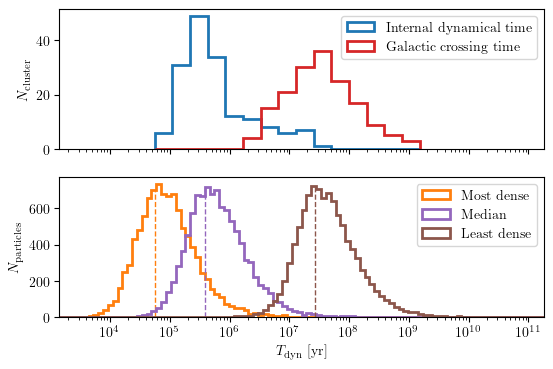

In [6]:
fig,axis=plt.subplots(2,1,figsize=(8.25-2,4),sharex=True, gridspec_kw={'height_ratios': [1, 1]})
axis[0].hist(tdyn.value, bins=binednges,  histtype='step', color='tab:blue', lw=2, label=r"$\mathrm{Internal~dynamical~time}$")
axis[0].hist(tcrossGCs.value, bins=binednges,  histtype='step', color='tab:red', lw=2, label=r"$\mathrm{Galactic~crossing~time}$")
axis[0].set_xscale('log')
axis[1].set_xlabel(r'$T_{\mathrm{dyn}}~[\mathrm{yr}]$', fontsize="medium")
axis[0].set_ylabel(r'$N_{\mathrm{cluster}}$', fontsize="medium")
ylims = axis[0].get_ylim()
axis[0].set_ylim(0, ylims[1])
# axis[0].set_xlim(3e4,5e9)
axis[0].legend(fontsize="medium", loc='best')

colors = ['tab:orange', 'tab:purple', 'tab:brown']
bin_ceneters = 0.5*(bins[1:] + bins[:-1])
for i in range(len(indexes)):
    index = indexes[i]
    xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G.value,GCdata['Mass'][index].value,GCdata['rh_m'][index].value, NP)
    rp,vp = np.sqrt(xp**2 + yp**2 + zp**2), np.sqrt(vxp**2 + vyp**2 + vzp**2)
    tcrossP = rp/vp
    tcrossP = (tcrossP*u.Unit(tstrippy.Parsers.unitbasis['time'])).to(u.yr)
    counts,_,_=axis[1].hist(tcrossP.value, bins=bins, histtype='step', lw=2, label=labels[i],color=colors[i])
    # find the counts at the median tdyn 
    myindex = np.argmin(np.abs(bin_ceneters - tdyn[index].value))
    axis[1].vlines(tdyn[index].value, 0, counts[myindex], color=colors[i], linestyle='--', lw=1, )
    print(np.median(tcrossP).value/tdyn[index].value)

axis[1].set_xlim(tmin.value, tmax.value)
axis[1].legend(fontsize="medium", loc='best')
axis[1].set_xscale('log')
axis[1].set_ylabel(r'$N_{\mathrm{particles}}$', fontsize="medium")

fig.savefig("../../images/GCsystemCharacteristicTimes.png", bbox_inches='tight', dpi=300)

We see that the tails overlap, are there any cluster's whose internal crossing time is longer than the galactic crossing time?

In [7]:
print(np.sum(tdyn > tcrossGCs))

0


no, there are not. Good to know. What are the ratio's? 

In [8]:
least_stable_threshold,most_stable_threshold = 10,500
ratio = tcrossGCs/tdyn
criteria=ratio < least_stable_threshold
least_stable = GCdata['Cluster'][criteria]
least_stable_ratio = ratio[criteria]
least_stable_sort = np.argsort(least_stable_ratio)
least_stable_sorted = least_stable[least_stable_sort]
criteria = ratio > most_stable_threshold
most_stable = GCdata['Cluster'][criteria]
most_stable_ratio = ratio[criteria]
most_stable_sort = np.argsort(most_stable_ratio)
most_stable_sorted = most_stable[most_stable_sort]

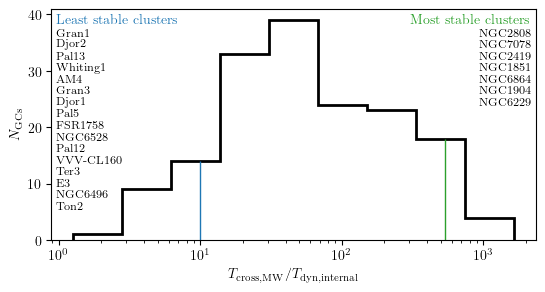

In [9]:
bins = np.logspace(np.log10(ratio.min().value), np.log10(ratio.max().value) , int(np.sqrt(nbins)))
centers = 0.5*(bins[1:] + bins[:-1])
fig,axis=plt.subplots(1,1,figsize=(8.25-2,3))
counts,_,_=axis.hist(ratio.value, bins=bins, histtype='step', lw=2, color='black')
# find the intersection of the counts with the median tdyn
index_least = np.argmin(np.abs(centers-least_stable_threshold))
index_most = np.argmin(np.abs(centers-most_stable_threshold))
axis.vlines(centers[index_least], 0, counts[index_least], color='tab:blue', linestyle='-', lw=1, )
axis.vlines(centers[index_most], 0, counts[index_most], color='tab:green', linestyle='-', lw=1,)
axis.set_xscale('log')
axis.set_xlabel(r'$T_{\mathrm{cross,MW}}/T_{\mathrm{dyn,internal}}$', fontsize="medium")
axis.set_ylabel(r'$N_{\mathrm{GCs}}$', fontsize="medium")
axis.text(0.01, 0.925, r"$\mathrm{Least~stable~clusters}$", fontsize="medium", color='tab:blue',transform=axis.transAxes,ha='left', va='bottom')
for i in range(len(least_stable)):
    axis.text(0.01, 0.875 - i*0.05, least_stable_sorted[i], fontsize="small", color='black',transform=axis.transAxes,ha='left', va='bottom')

axis.text(0.99, 0.925, r"$\mathrm{Most~stable~clusters}$", fontsize="medium", color='tab:green',transform=axis.transAxes,ha='right', va='bottom')
for i in range(len(most_stable)):
    axis.text(0.99, 0.875 - i*0.05, most_stable_sorted[i], fontsize="small", color='black',transform=axis.transAxes,ha='right', va='bottom')

fig.savefig("../../images/GCsystemStabilityDynamicalTimeRatios.png", bbox_inches='tight', dpi=300)

what's the most typical globular cluster?

In [31]:
dTdyn = (np.log10(tdyn.value) - np.log10(np.median(tdyn).value)) / np.log10(np.median(tdyn).value)
dCross = (np.log10(tcrossGCs.value) - np.log10(np.median(tcrossGCs).value)) / np.log10(np.median(tcrossGCs).value)
typicaldex=np.argmin(np.abs(dTdyn) + np.abs(dCross))
# medianIndex = np.argmin(np.abs(ratio-np.median(ratio)))
# typicalGC = GCdata['Cluster'][medianIndex]
# GCdata['Mass'][medianIndex]
print(f"Most typical globular cluster: {GCdata['Cluster'][typicaldex]}")
print(f"Mass: {GCdata['Mass'][typicaldex]} Msun")
print(f"Internal dynamical time: {tdyn[typicaldex]}")
print(f"Galactic crossing time: {tcrossGCs[typicaldex]}")
print(f"Ratio: {tcrossGCs[typicaldex]/tdyn[typicaldex]}")
print(f"R half mass: {GCdata['rh_m'][typicaldex]}")

Most typical globular cluster: NGC6760
Mass: 286000.0 solMass Msun
Internal dynamical time: 383398.89404155954 yr
Galactic crossing time: 31467033.00751118 yr
Ratio: 82.07387526814365
R half mass: 0.00574 kpc


## 

## What is a good timestep for an isolated cluster?

Normalize the system to it's own length, G, and it's own mass.

what is the a typical globular cluster just to get an idea of the timescales involved?

In [10]:
integration_time = int(5e9/np.median(tdyn).value)
print("Number of dynamical times for our experiment", integration_time)

Number of dynamical times for our experiment 12843


In [11]:
G,M,a = 1,1,1
NP = int(1e2)
tau = np.sqrt(a**3 / (G*M))

how to pick the time step? 

$$ \Delta t = \frac{T}{2^{k-1}} $$

where $N=2^{k-1}$, and $k$ is the number of intervals and $N$ is the number of steps. Note that we want the timestep to be some fraction of the dynamical time: 

$$ \alpha \Delta t = \tau$$

where $0<\alpha<1$. So, given an $\alpha$, we want to find the number of steps such that $k$ and $N$ are integers. This becomes: 

$$ \log_2 \left(\frac{T}{\alpha \tau} \right) + 1 < k$$


This means, we can take the expression on the left side of the inequality and round it up for the lowest possible value of $k$. If $\alpha = 1/100$ and $T = 1200\tau$, Then $k$ becomes: 

In [12]:
integration_time = 10
alpha = 1/100
k = np.ceil(np.log2(integration_time / alpha / tau ) + 1) 
NSTEPS = int(2**(k-1))
dt = alpha * tau 
print(NSTEPS, "number of steps")

1024 number of steps


Prepare the arugments into batches for quicker comp time

In [242]:
# NOTE batch for parallelization
alphas = [1, 1/10, 1/100, 1/1000, 1/10000]
inverse_alphas = [int(1/a) for a in alphas]
RESULTS = {}

NP = int(1e3)
NSTEPS,dt,alpha_out,args = [],[],[],[]
staticgalaxy = ["plummer", [G, M, tstrippy.ergodic.convertHalfMassRadiusToPlummerRadius(a)]]
for i in range(len(alphas)):
    alpha = alphas[i]
    k = np.ceil(np.log2(integration_time / alpha / tau ) + 1) 
    alpha_out_temp = integration_time / 2**(k-1) / tau
    # NSTEPS.append(int(2**(k-1)))
    NSTEPS.append(1)
    dt.append(alpha_out_temp * tau)
    alpha_out.append(alpha_out_temp)
    integrationparams = [0, dt[i], NSTEPS[i]]
    initialkinematics = np.array(tstrippy.ergodic.isotropicplummer(G, M, a, NP))
    args.append( [integrationparams, staticgalaxy, initialkinematics] )
    RESULTS[inverse_alphas[i]] = {
        "integrationparams": integrationparams,
        "staticgalaxy": staticgalaxy,
        "initialkinematics": initialkinematics,
        "NSTEPS": NSTEPS[i],
        "dt": dt[i],
        "alpha_out": alpha_out_temp,
        "args": args[i]
    }

In [243]:
# perform the computation 
stream,compTimes = NEF.leapfrogtofinalpositions(args[0])
RESULTS[inverse_alphas[0]]['stream'] = stream
RESULTS[inverse_alphas[0]]['compTimes'] = compTimes
print("Computation time for alpha = ", inverse_alphas[0], "is", compTimes)
stream,compTimes = NEF.leapfrogtofinalpositions(args[1])
RESULTS[inverse_alphas[1]]['stream'] = stream
RESULTS[inverse_alphas[1]]['compTimes'] = compTimes
print("Computation time for alpha = ", inverse_alphas[1], "is", compTimes)
stream,compTimes = NEF.leapfrogtofinalpositions(args[2])
RESULTS[inverse_alphas[2]]['stream'] = stream
RESULTS[inverse_alphas[2]]['compTimes'] = compTimes
print("Computation time for alpha = ", inverse_alphas[2], "is", compTimes)

Computation time for alpha =  1 is 0:00:00.001758
Computation time for alpha =  10 is 0:00:00.001723
Computation time for alpha =  100 is 0:00:00.001663


In [244]:
# NOW START DOING BATCHES FOR THE LONGER INTEGRATIONS
freecpu = 2
ncpu = mp.cpu_count() - freecpu
nbatches = ncpu 
stream,compTimes = NEF.batch_leapfrogtofinalpositions(args[3], ncpu, freecpu=freecpu)
RESULTS[inverse_alphas[3]]['stream'] = stream
RESULTS[inverse_alphas[3]]['compTimes'] = compTimes
print("Computation time for alpha = ", inverse_alphas[3], "is", np.sum(compTimes))
print("parallelization done with", ncpu, "CPUs", "in", np.max(compTimes))
print("speed up", np.sum(compTimes) / np.max(compTimes))
# for the highest resolution 
stream,compTimes = NEF.batch_leapfrogtofinalpositions(args[4], ncpu, freecpu=freecpu)
RESULTS[inverse_alphas[4]]['stream'] = stream
RESULTS[inverse_alphas[4]]['compTimes'] = compTimes
print("Computation time for alpha = ", inverse_alphas[4], "is", np.sum(compTimes))
print("parallelization done with", ncpu, "CPUs", "in", np.max(compTimes), "seconds")

Running 6 batches with 6 CPUs, each with 166 particles
Computation time for alpha =  1000 is 0:00:00.000371
parallelization done with 6 CPUs in 0:00:00.000114
speed up 3.254385964912281
Running 6 batches with 6 CPUs, each with 166 particles
Computation time for alpha =  10000 is 0:00:00.000393
parallelization done with 6 CPUs in 0:00:00.000123 seconds


how is the energy conservation for each one?


In [287]:
# lemme just do the whole thing again quick 
integrationparams = [0, 1/5000, 1000]
xp,yp,zp,vzp,vyp,vzp = tstrippy.ergodic.isotropicplummer(G, M, a, NP)
initialkinematics = np.array([xp,yp,zp,vxp,vyp,vzp])
staticgalaxy = ["plummer", [G, M, tstrippy.ergodic.convertHalfMassRadiusToPlummerRadius(a)]]
tstrippy.integrator.deallocate()
tstrippy.integrator.setintegrationparameters(*integrationparams)
tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
tstrippy.integrator.setinitialkinematics(*initialkinematics)
# integrate 
tstrippy.integrator.leapfrogtofinalpositions()
xf,yf,zf = tstrippy.integrator.xf.copy(), tstrippy.integrator.yf.copy(), tstrippy.integrator.zf.copy()
vxf,vyf,vzf = tstrippy.integrator.vxf.copy(), tstrippy.integrator.vyf.copy(), tstrippy.integrator.vzf.copy()
tstrippy.integrator.deallocate()
# # do the same thing but leap in time 
tstrippy.integrator.setintegrationparameters(*integrationparams)
tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
tstrippy.integrator.setinitialkinematics(*initialkinematics)
xt,yt,zt,vxt,vyt,vzt = tstrippy.integrator.leapfrogintime(integrationparams[-1],NP)
xft,yft,zft = tstrippy.integrator.xf.copy(), tstrippy.integrator.yf.copy(), tstrippy.integrator.zf.copy()
vxft,vyft,vzft =  tstrippy.integrator.vxf.copy(), tstrippy.integrator.vyf.copy(), tstrippy.integrator.vzf.copy()
# deallocate the integrator
tstrippy.integrator.deallocate()


In [300]:
zf[-1]

np.float64(0.2939400499349352)

In [301]:
zft[-1],zft[-1]

(np.float64(0.2939400499349352), np.float64(0.2939400499349352))

In [302]:
print((xf[0]-xp[0])/xp[0],(yf[0]-yp[0])/yp[0],(zf[0]-zp[0])/zp[0])
print((vxf[0]-vxp[0])/vxp[0],(vyf[0]-vyp[0])/vyp[0],(vzf[0]-vzp[0])/vzp[0])


-0.0021675344530957008 0.020094754524759936 0.00023729068409834882
0.0008846016393440834 -9.643422165980274e-05 -0.008053993148596447


In [303]:
initialkinematics[3][0],vxf[0]

(np.float64(-0.1281513147341226), np.float64(-0.12826467759722052))

In [304]:
initialkinematics[0][0],xf[0]

(np.float64(11.829847632075484), np.float64(11.804206029758088))

In [305]:
# _,_,_,phi0 = tstrippy.potentials.plummer([G, M, a],  xp,yp,zp)
_,_,_,phi0 = tstrippy.potentials.plummer([G, M, a],  initialkinematics[0],initialkinematics[1],initialkinematics[2])
T0 = 0.5 * (vxp**2 + vyp**2 + vzp**2)
myE0 = T0 + phi0
_,_,_,phif = tstrippy.potentials.plummer([G, M, a], xf, yf, zf)
Tf = 0.5 * (vxf**2 + vyf**2 + vzf**2)
myEF = Tf + phif
errE = np.abs((myEF - myE0) / myE0)

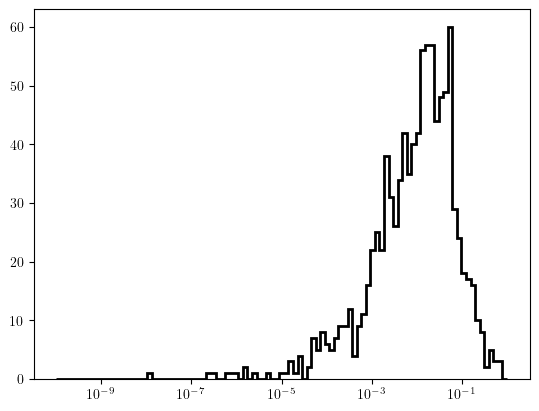

In [306]:
bins = np.logspace(-10, 0, 100)
plt.hist(errE,bins=bins, histtype='step', lw=2, color='black')
plt.xscale('log')

In [307]:
RESULTS[1]['initialkinematics'][0][0:5]

array([-0.21786767, -0.00859949,  0.81291931,  0.24282003,  0.47663838])

In [308]:
args[0][-1][0,0:5]  # This is the initialkinematics for alpha = 1

array([-0.21786767, -0.00859949,  0.81291931,  0.24282003,  0.47663838])

In [309]:
xp0,yp0,zp0,vxp0,vyp0,vzp0=RESULTS[1]['initialkinematics']
xpf,ypf,zpf,vxpf,vypf,vzpf=RESULTS[1]['stream']

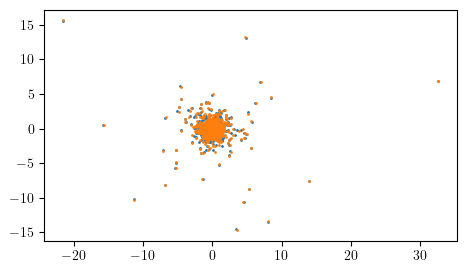

In [310]:
fig,axis=plt.subplots(1,1,figsize=(8.25-2,3))
axis.scatter(xp0,yp0,s=1)
axis.scatter(xpf,ypf,s=1, color='tab:orange')
axis.set_aspect('equal')

In [311]:
xp0[0]

np.float64(-0.21786766724300716)

In [312]:
E0,EF,errE = [],[],[]

for i in range(len(alphas)):
    alpha = inverse_alphas[i]
    xp0,yp0,zp0,vxp0,vyp0,vzp0=RESULTS[alpha]['initialkinematics']
    _,_,_,phi0 = tstrippy.potentials.plummer([G,M,a],xp0,yp0,zp0)
    T0 = 0.5 * (vxp0**2 + vyp0**2 + vzp0**2)
    myE0 = T0 + phi0
    E0.append(myE0)
    xpf,ypf,zpf,vxpf,vypf,vzpf=RESULTS[alpha]['stream']
    _,_,_,phif = tstrippy.potentials.plummer([G,M,a],xpf,ypf,zpf)
    Tf = 0.5 * (vxpf**2 + vypf**2 + vzpf**2)
    myEF = Tf + phif
    EF.append(myEF)
    errE.append(np.abs((myEF - myE0)/myE0))

Text(0, 0.5, '$\\mathrm{Relative~energy~error}$')

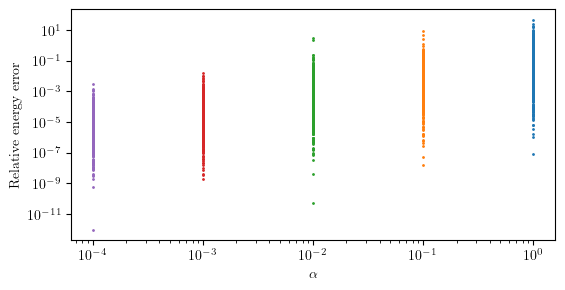

In [313]:
fig,axis=plt.subplots(1,1,figsize=(8.25-2,3))
for i in range(len(alphas)):
    myalpha = inverse_alphas[i]
    axis.scatter(1/myalpha * np.ones_like(errE[i]), errE[i], s=1, label=r"$\alpha = " + str(alphas[i]) + "$", color=mpl.colormaps['tab10'](i))
axis.set_yscale('log')
axis.set_xscale('log')
axis.set_xlabel(r"$\alpha$", fontsize="medium")
axis.set_ylabel(r"$\mathrm{Relative~energy~error}$", fontsize="medium")

In [314]:
# # TOTAL COMPUTATION TIME!!
# RAM = NSTEPS*NP*6*8*u.byte
# print(RAM.to(u.GB), "GB RAM required for this simulation"   )
# calc_time_per_step = 30e-9
# print(calc_time_per_step*NSTEPS*NP, "seconds")
# # CPU hours? 
# dts = tdyn*alpha
# nsteps = (5e9*u.year) / dts
# nsteps = np.array([int(nstep.value) for nstep in nsteps])
# np.sum(nsteps*calc_time_per_step*1e5)/60/60/24

In [345]:
integrationparams = args[2][0]
initialkinetmatics = args[2][-1]
NSTEP = integrationparams[-1]
integrationparams = [0, 1/1000, 1000]
NSTEP = integrationparams[-1]

In [346]:
tstrippy.integrator.deallocate()
tstrippy.integrator.setinitialkinematics(*initialkinetmatics)
tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
tstrippy.integrator.setintegrationparameters(*integrationparams)
xt,yt,zt,vxt,vyt,vzt=tstrippy.integrator.leapfrogintime(NSTEP,NP)
# grab these final positions and velocities
xft,yft,zft = tstrippy.integrator.xf.copy(), tstrippy.integrator.yf.copy(), tstrippy.integrator.zf.copy()
vxft,vyft,vzft = tstrippy.integrator.vxf.copy(), tstrippy.integrator.vyf.copy(), tstrippy.integrator.vzf.copy()
tstrippy.integrator.deallocate()
# now do it just to final positions
tstrippy.integrator.setinitialkinematics(*initialkinetmatics)
tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
tstrippy.integrator.setintegrationparameters(*integrationparams)
startime = datetime.datetime.now()
tstrippy.integrator.leapfrogtofinalpositions()
xf,yf,zf = tstrippy.integrator.xf.copy(), tstrippy.integrator.yf.copy(), tstrippy.integrator.zf.copy()
vxf,vyf,vzf = tstrippy.integrator.vxf.copy(), tstrippy.integrator.vyf.copy(), tstrippy.integrator.vzf.copy()
tstrippy.integrator.deallocate()
endtime = datetime.datetime.now()
comptime = endtime - startime
print(f"Integration took {comptime} seconds")
tstrippy.integrator.deallocate()
step_time = comptime.total_seconds() / NSTEP / NP
print(f"Step time: {step_time} seconds")

Integration took 0:00:00.421904 seconds
Step time: 4.2190400000000004e-07 seconds


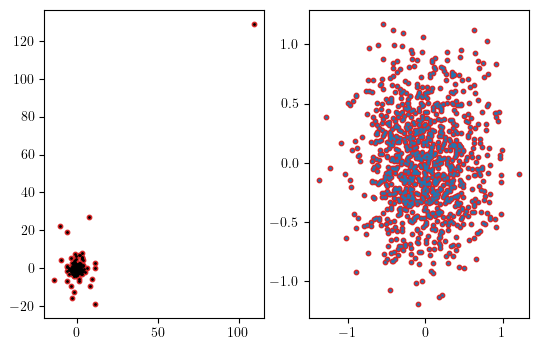

In [347]:
fig,axis=plt.subplots(1,2,figsize=(8.25-2,4),)
# axis.scatter(xp, yp, s=1, c='tab:blue', label=r"$\mathrm{Initial~positions}$")
# axis[0].scatter(xf[0], yf[0], s=10, c='tab:red', label=r"$\mathrm{Final~positions}$")
axis[0].scatter(xf, yf, s=10, c='tab:red', label=r"$\mathrm{Final~positions}$")
axis[0].scatter(xft, yft, s=1, c='k', label=r"$\mathrm{Final~positions~from~integrator}$"  )
# axis[0].scatter(xft[0], yft[0], s=10, c='k', label=r"$\mathrm{Final~positions~from~integrator}$"  )
# axis[0].set_aspect('equal')

axis[1].scatter(vxf, vyft, s=10, c='tab:red', label=r"$\mathrm{Final~velocities}$")
axis[1].scatter(vxf, vyft, s=1, c='tab:blue', label=r"$\mathrm{Final~velocities}$")


In [348]:
# measure the potential energy NOW 
phi = np.zeros_like(xt)
T = np.zeros_like(xt)
for i in range(NP):
    _,_,_,phi[i,:]=tstrippy.potentials.plummer(staticgalaxy[1],xt[i],yt[i],zt[i])
    T[i,:] = 0.5 * (vxt[i]**2 + vyt[i]**2 + vzt[i]**2)
E = T + phi
timestemps = np.linspace(0, integration_time, NSTEP+1)

E0=E[:,0]
E0=E0[:,np.newaxis]
errE = np.abs((E - E0) / E0)
print(E0[0])

[-0.55395287]


In [349]:
# color based on how eccentric the orbit is
rp = np.sqrt(xp**2 + yp**2 + zp**2)
v = np.sqrt(vxp**2 + vyp**2 + vzp**2)
v_r = (xp*vxp + yp*vyp + zp*vzp) / rp
ecc_quick = (abs(v_r) / v)**2

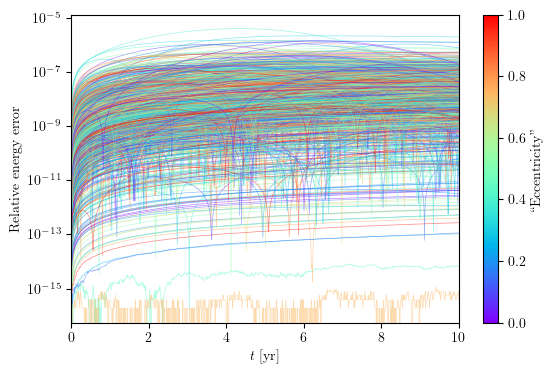

In [350]:
vmin = E0.min()
vmax = E0.max() 
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.rainbow
colors = cmap(norm(E[:,0]))
# color based on how eccentric the orbit is
rp = np.sqrt(xp**2 + yp**2 + zp**2)
v = np.sqrt(vxp**2 + vyp**2 + vzp**2)
v_r = (xp*vxp + yp*vyp + zp*vzp) / rp
ecc_quick = abs(v_r) / v
norm = mpl.colors.Normalize(vmin=0, vmax=1)
colors = cmap(ecc_quick)
NSKIP = 1
fig,axis = plt.subplots(1, 1, figsize=(8.25-2, 4))
for i in range(NP):
    axis.plot(timestemps[::NSKIP], errE[i,::NSKIP], lw=0.5, alpha=0.5,color=colors[i])
axis.set_yscale("log")
axis.set_xlabel(r'$t~[\mathrm{yr}]$', fontsize="medium")
axis.set_ylabel(r'$\mathrm{Relative~energy~error}$', fontsize="medium")
axis.set_xlim(0, integration_time)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axis)
cbar.set_label(r'$``\mathrm{Eccentricity}"$', fontsize="medium")


In [62]:
E0[0]

np.float64(-0.13548477401451725)

In [66]:
xp,yp,zp,vxp,vyp,vzp = initialkinetmatics

In [338]:
staticgalaxy[1]

[1, 1, 0.7664209365408798]

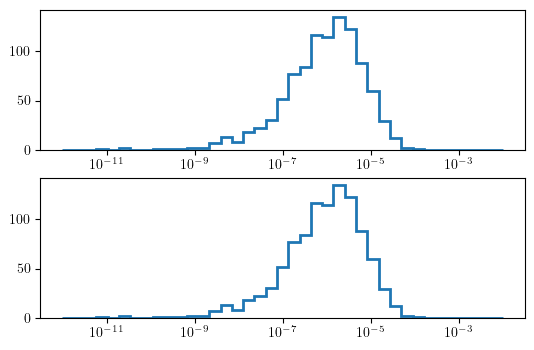

In [67]:
bins=np.logspace(-12,-2, 40)
_,_,_,phi0=tstrippy.potentials.plummer(staticgalaxy[1],xp,yp,zp)
T0 = 0.5 * (vxp**2 + vyp**2 + vzp**2)
E0 = T0 + phi0
_,_,_,phif=tstrippy.potentials.plummer(staticgalaxy[1],xf,yf,zf)
Tf = 0.5 * (vxf**2 + vyf**2 + vzf**2)
Ef = Tf + phif

errEF = (Ef - E0)/E0

fig,axis=plt.subplots(2,1,figsize=(8.25-2,4))
axis[0].hist(np.abs(errEF), bins=bins, histtype='step', lw =2, color='tab:blue');
axis[1].hist(np.abs(errE[:,-1]), bins=bins, histtype='step', lw =2, color='tab:blue');
axis[0].set_xscale('log')
axis[1].set_xscale('log')